создаем опорный пример для работы с регресиями и оценками гипотез по стьюденту для связных выборок на основе.
https://habr.com/ru/company/ods/blog/336168/

Пусть истинная зависимость — синус, добавим нормальный шум и добавим нормальные же выбросы (на 15% объектов выбросы поменьше, на 4% — побольше):

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


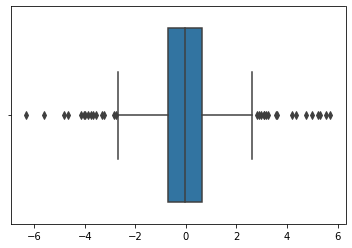

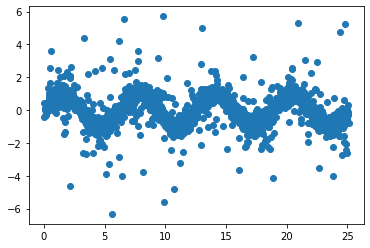

In [46]:
import numpy as np
import seaborn as sns
import numpy as np
%pylab inline
np.random.seed(3)
X = 8 * 3.1415 * np.random.random_sample(size=2000)
y = np.sin(X) + np.random.normal(size=X.size, scale=0.3)
outliers_1 = np.random.randint(low=0, high=X.shape[0], size=int(X.shape[0] * 0.15))
y[outliers_1] += np.random.normal(size=outliers_1.size, scale=1)
outliers_2 = np.random.randint(low=0, high=X.shape[0], size=int(X.shape[0] * 0.04))
y[outliers_2] += np.random.normal(size=outliers_2.size, scale=3)
data = y
sns.boxplot(data)
plt.show()
plt.scatter(x=X, y=y)
plt.show()

Text(0, 0.5, 'score')

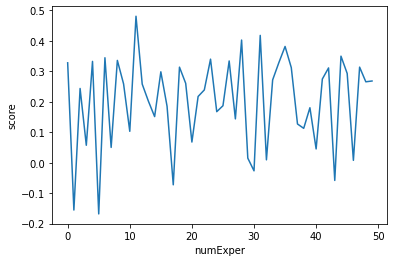

In [88]:
import xgboost as xgb
from sklearn.model_selection import cross_val_score,KFold
from scipy.stats import ttest_rel
X_train = X[:int(X.shape[0]/2)].reshape(-1,1)
y_train = y[:int(X.shape[0]/2)]
X_test = X[int(X.shape[0]/2):].reshape(-1,1)
y_test = y[int(X.shape[0]/2):]
base_scores_train = np.array([])
for i in range(10):
    fold = KFold(n_splits=5, shuffle=True, random_state=i)
    scores_on_this_split = cross_val_score(
                                     estimator=xgb.XGBRegressor(
                                             n_estimators=110,
                                             min_child_weight=2),
                                     X=X_train, y=y_train,
                                     cv=fold, scoring='r2')
    base_scores_train = np.append(base_scores_train,
                                  scores_on_this_split)
plt.plot(range(0, 50), base_scores_train)
plt.xlabel('numExper')
plt.ylabel('score')

попробуем поменять колличество деревьев. 
посмотрим как они похожи друг на друга.

Text(0, 0.5, 'score')

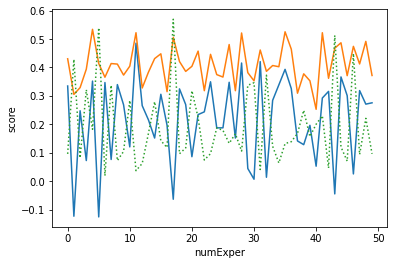

In [64]:
numTrees = 9
scores_train = np.array([])
for i in range(10):
    fold = KFold(n_splits=5, shuffle=True, random_state=i)
    scores_on_this_split = cross_val_score(
                                estimator=xgb.XGBRegressor(
                                    n_estimators=numTrees, min_child_weight=2),
                                X=X_train, y=y_train, cv=fold, scoring='r2')
    scores_train = np.append(scores_train,
                             scores_on_this_split)

plt.plot(range(0, 50), base_scores_train)
plt.plot(range(0, 50), scores_train,'-')
plt.plot(range(0, 50), scores_train-base_scores_train,':')
plt.xlabel('numExper')
plt.ylabel('score')

давайте используем критерий стьюдента для связных выборок

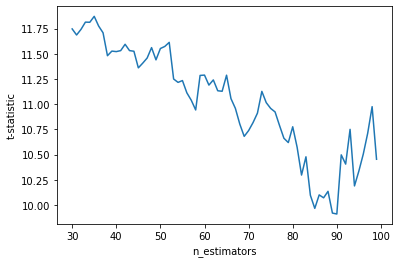

Text(0, 0.5, 't-p_value')

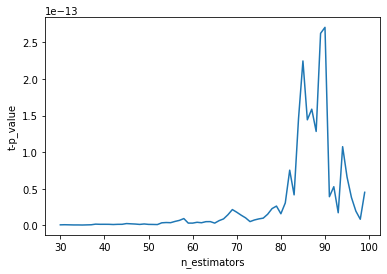

In [89]:
t_stats_train = []
t_p_value = []
for j in range(30, 100):
    scores_train = np.array([])
    for i in range(10):
        fold = KFold(n_splits=5, shuffle=True, random_state=i)
        scores_on_this_split = cross_val_score(
                                    estimator=xgb.XGBRegressor(
                                        n_estimators=j, min_child_weight=2),
                                    X=X_train, y=y_train, cv=fold, scoring='r2')
        scores_train = np.append(scores_train,
                                 scores_on_this_split)
    t_stat,p_value = ttest_rel(scores_train, base_scores_train)
    t_stats_train.append(t_stat)
    t_p_value.append(p_value)
plt.plot(range(30, 100), t_stats_train)
plt.xlabel('n_estimators')
plt.ylabel('t-statistic')
plt.show()
plt.plot(range(30, 100), t_p_value)
plt.xlabel('n_estimators')
plt.ylabel('t-p_value')

теперь сравним со второй частью данных

Text(0, 0.5, 'r2_score_test')

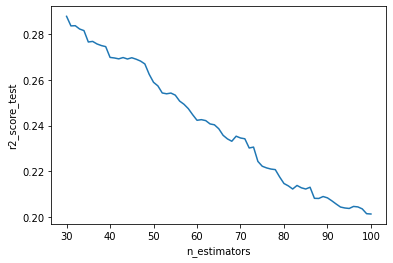

In [90]:
from sklearn.metrics import r2_score

est_base = xgb.XGBRegressor(min_child_weight=2)
est_base.fit(X_train, y_train)
base_scores_test = r2_score(y_test, est_base.predict(X_test))
scores_test = []
for i in range(30,101):
    est = xgb.XGBRegressor(n_estimators=i, min_child_weight=2)
    est.fit(X_train,y_train)
    scores_test.append(r2_score(y_test, est.predict(X_test)))
plt.plot(range(30, 101), scores_test)
plt.xlabel('n_estimators')
plt.ylabel('r2_score_test')